<a href="https://colab.research.google.com/github/a20233855-max/EvaluacionUnemploy/blob/main/trabajo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/TheThematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map


In [122]:
import geopandas as gpd

linkGit='https://github.com/a20233855-max/EvaluacionUnemploy/raw/refs/heads/main/'
linkWorldMaps='worldMaps.gpkg'

In [123]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


In [124]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


In [125]:
import pandas as pd

someDataLink='Unemploymentrate.csv'

someData=pd.read_csv(linkGit+someDataLink)

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 190 non-null    object 
 1   slug                 190 non-null    object 
 2   %                    190 non-null    float64
 3   date_of_information  190 non-null    int64  
 4   ranking              190 non-null    int64  
 5   region               190 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.0+ KB


In [126]:
someData.rename(columns={'name': 'Country'}, inplace=True)

## Pre Processing: Merging

In [127]:
someData.head()

,Country,slug,%,date_of_information,ranking,region
0,Qatar,qatar,0.2,2024,1,Middle East
1,Cambodia,cambodia,0.3,2024,2,East and Southeast Asia
2,Niger,niger,0.4,2024,3,Africa
3,Thailand,thailand,0.7,2024,4,East and Southeast Asia
4,Burundi,burundi,1.0,2024,5,Africa


Preparing thematic maps requires **social data** _about_ the geometry (line, polygon, point). The object **countries** has no social data, so the preprocessing requires geomerging.

### Geo Merging


In [128]:
countries.COUNTRY.head()

,COUNTRY
0,Aruba (Netherlands)
1,Antigua and Barbuda
2,Afghanistan
3,Algeria
4,Azerbaijan


In [129]:
someData.name.head()

,Country
0,Qatar
1,Cambodia
2,Niger
3,Thailand
4,Burundi


Let's solve the _country name_ differences for the KEYs:

In [130]:
countries.rename(columns={'COUNTRY':'Country'},inplace=True)

We can notice the different *case* in the KEYs. Let's work with uppercases:

In [131]:
countries['Country']=countries.Country.str.upper()

It is very unlikely the names are written the same. Let's verify:

In [132]:
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

Check here:

In [133]:
onlyDF # they did not find a match in the MAP GDF!

{'Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Democratic Republic of the',
 'Congo, Republic of the',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gabon',
 'Gambia, The',
 'Gaza Strip',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guam',
 'Guatemala',
 'Guernsey',
 'Guinea',
 'Guinea-Bissau',
 'Gu

### Fuzzy merging

In [134]:
!pip install thefuzz

This is the basic idea:

In [135]:
from thefuzz.process import extractOne as best

## find the BEST match to 'BAHAMAS (THE)'
## from all strings in 'onlyGDF'

best('Bahamas, The',onlyGDF)

('BAHAMAS', 90)

As you see, you get a coefficient value of 90 (the closer to 100 the better). That may be a reliable result.

Let's do the same for all the unmatched countries:

In [136]:
## for each country in onlyDF, find the BEST match in onlyGDF

[(country, best(country,onlyGDF)) for country in onlyDF]

[('Russia', ('RUSSIA', 100)),
 ('Benin', ('BENIN', 100)),
 ('Guinea-Bissau', ('GUINEA-BISSAU', 100)),
 ('Ghana', ('GHANA', 100)),
 ('Pakistan', ('PAKISTAN', 100)),
 ("Cote d'Ivoire", ('IVORY COAST', 63)),
 ('Georgia', ('GEORGIA', 100)),
 ('Switzerland', ('SWITZERLAND', 100)),
 ('Uruguay', ('URUGUAY', 100)),
 ('Timor-Leste', ('EAST TIMOR', 81)),
 ('United Kingdom', ('UNITED KINGDOM', 100)),
 ('Kyrgyzstan', ('KYRGYZSTAN', 100)),
 ('Tanzania', ('TANZANIA', 100)),
 ('Jordan', ('JORDAN', 100)),
 ('Morocco', ('MOROCCO', 100)),
 ('Brazil', ('BRAZIL', 100)),
 ('Slovakia', ('SLOVAKIA', 100)),
 ('Dominican Republic', ('DOMINICAN REPUBLIC', 100)),
 ('Fiji', ('FIJI', 100)),
 ('Finland', ('FINLAND', 100)),
 ('Bhutan', ('BHUTAN', 100)),
 ('Jamaica', ('JAMAICA', 100)),
 ('Zambia', ('ZAMBIA', 100)),
 ('Yemen', ('YEMEN', 100)),
 ('Saint Vincent and the Grenadines', ('ST. VINCENT AND THE GRENADINES', 94)),
 ('Cabo Verde', ('CAPE VERDE', 80)),
 ('Malawi', ('MALAWI', 100)),
 ('Gambia, The', ('GAMBIA', 90)

In [137]:
#or
[(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]

[('Russia', 'RUSSIA', 100),
 ('Benin', 'BENIN', 100),
 ('Guinea-Bissau', 'GUINEA-BISSAU', 100),
 ('Ghana', 'GHANA', 100),
 ('Pakistan', 'PAKISTAN', 100),
 ("Cote d'Ivoire", 'IVORY COAST', 63),
 ('Georgia', 'GEORGIA', 100),
 ('Switzerland', 'SWITZERLAND', 100),
 ('Uruguay', 'URUGUAY', 100),
 ('Timor-Leste', 'EAST TIMOR', 81),
 ('United Kingdom', 'UNITED KINGDOM', 100),
 ('Kyrgyzstan', 'KYRGYZSTAN', 100),
 ('Tanzania', 'TANZANIA', 100),
 ('Jordan', 'JORDAN', 100),
 ('Morocco', 'MOROCCO', 100),
 ('Brazil', 'BRAZIL', 100),
 ('Slovakia', 'SLOVAKIA', 100),
 ('Dominican Republic', 'DOMINICAN REPUBLIC', 100),
 ('Fiji', 'FIJI', 100),
 ('Finland', 'FINLAND', 100),
 ('Bhutan', 'BHUTAN', 100),
 ('Jamaica', 'JAMAICA', 100),
 ('Zambia', 'ZAMBIA', 100),
 ('Yemen', 'YEMEN', 100),
 ('Saint Vincent and the Grenadines', 'ST. VINCENT AND THE GRENADINES', 94),
 ('Cabo Verde', 'CAPE VERDE', 80),
 ('Malawi', 'MALAWI', 100),
 ('Gambia, The', 'GAMBIA', 90),
 ('Maldives', 'MALDIVES', 100),
 ('Venezuela', 'VENEZ

In [138]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF])

,0,1,2
0,Russia,RUSSIA,100
1,Benin,BENIN,100
2,Guinea-Bissau,GUINEA-BISSAU,100
3,Ghana,GHANA,100
4,Pakistan,PAKISTAN,100
...,...,...,...
185,Guam,GUAM (US),90
186,Egypt,EGYPT,100
187,Equatorial Guinea,EQUATORIAL GUINEA,100
188,Qatar,QATAR,100


Let's sort by the column '2' (the third):

In [139]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(by=2)

,0,1,2
133,West Bank,BHUTAN,57
94,Gaza Strip,GHANA,60
5,Cote d'Ivoire,IVORY COAST,63
112,Macau,MAURITIUS,68
138,Hong Kong,CONGO,68
...,...,...,...
182,Thailand,THAILAND,100
186,Egypt,EGYPT,100
184,Burundi,BURUNDI,100
187,Equatorial Guinea,EQUATORIAL GUINEA,100


In [140]:
countries.Country[countries.Country.str.contains('SWAZ|LAO|SAMOA|KORE')]

,Country
9,AMERICAN SAMOA (US)
120,NORTH KOREA
122,SOUTH KOREA
126,LAOS
242,WESTERN SAMOA
243,SWAZILAND


At this stage, we should recompute the differences:

In [141]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

In [142]:
# keeping high scores

pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(2)

,0,1,2
133,West Bank,BHUTAN,57
94,Gaza Strip,GHANA,60
5,Cote d'Ivoire,IVORY COAST,63
112,Macau,MAURITIUS,68
138,Hong Kong,CONGO,68
...,...,...,...
182,Thailand,THAILAND,100
186,Egypt,EGYPT,100
184,Burundi,BURUNDI,100
187,Equatorial Guinea,EQUATORIAL GUINEA,100


In [143]:
# new {dictionary}
changesToDF={country: best(country,onlyGDF)[0] for country in onlyDF}
changesToDF

{'Russia': 'RUSSIA',
 'Benin': 'BENIN',
 'Guinea-Bissau': 'GUINEA-BISSAU',
 'Ghana': 'GHANA',
 'Pakistan': 'PAKISTAN',
 "Cote d'Ivoire": 'IVORY COAST',
 'Georgia': 'GEORGIA',
 'Switzerland': 'SWITZERLAND',
 'Uruguay': 'URUGUAY',
 'Timor-Leste': 'EAST TIMOR',
 'United Kingdom': 'UNITED KINGDOM',
 'Kyrgyzstan': 'KYRGYZSTAN',
 'Tanzania': 'TANZANIA',
 'Jordan': 'JORDAN',
 'Morocco': 'MOROCCO',
 'Brazil': 'BRAZIL',
 'Slovakia': 'SLOVAKIA',
 'Dominican Republic': 'DOMINICAN REPUBLIC',
 'Fiji': 'FIJI',
 'Finland': 'FINLAND',
 'Bhutan': 'BHUTAN',
 'Jamaica': 'JAMAICA',
 'Zambia': 'ZAMBIA',
 'Yemen': 'YEMEN',
 'Saint Vincent and the Grenadines': 'ST. VINCENT AND THE GRENADINES',
 'Cabo Verde': 'CAPE VERDE',
 'Malawi': 'MALAWI',
 'Gambia, The': 'GAMBIA',
 'Maldives': 'MALDIVES',
 'Venezuela': 'VENEZUELA',
 'Afghanistan': 'AFGHANISTAN',
 'Bolivia': 'BOLIVIA',
 'Botswana': 'BOTSWANA',
 'Panama': 'PANAMA',
 'Lesotho': 'LESOTHO',
 'Korea, South': 'SOUTH KOREA',
 'French Polynesia': 'FRENCH POLYNESI

In [144]:
someData.replace(to_replace={'Country':changesToDF},inplace=True)

In [145]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)
[(country, best(country,onlyGDF)) for country in onlyDF]

[]

In [146]:
## GDF to the 'left'
theMapAndData=countries.merge(someData, on='Country')

In [147]:
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              190 non-null    object  
 1   geometry             190 non-null    geometry
 2   slug                 190 non-null    object  
 3   %                    190 non-null    float64 
 4   date_of_information  190 non-null    int64   
 5   ranking              190 non-null    int64   
 6   region               190 non-null    object  
dtypes: float64(1), geometry(1), int64(2), object(3)
memory usage: 10.5+ KB


In [148]:
theMapAndData.to_file("worldindicators.json")

# Thematics: the DDM (Dot Density Map)


In [149]:

theMapAndData.region.value_counts()

,count
region,
Africa,53
Europe,41
East and Southeast Asia,20
Central America and the Caribbean,18
Middle East,16
South America,12
Australia and Oceania,10
Central Asia,9
South Asia,8


### Preprocessing: Filtering

<Axes: >

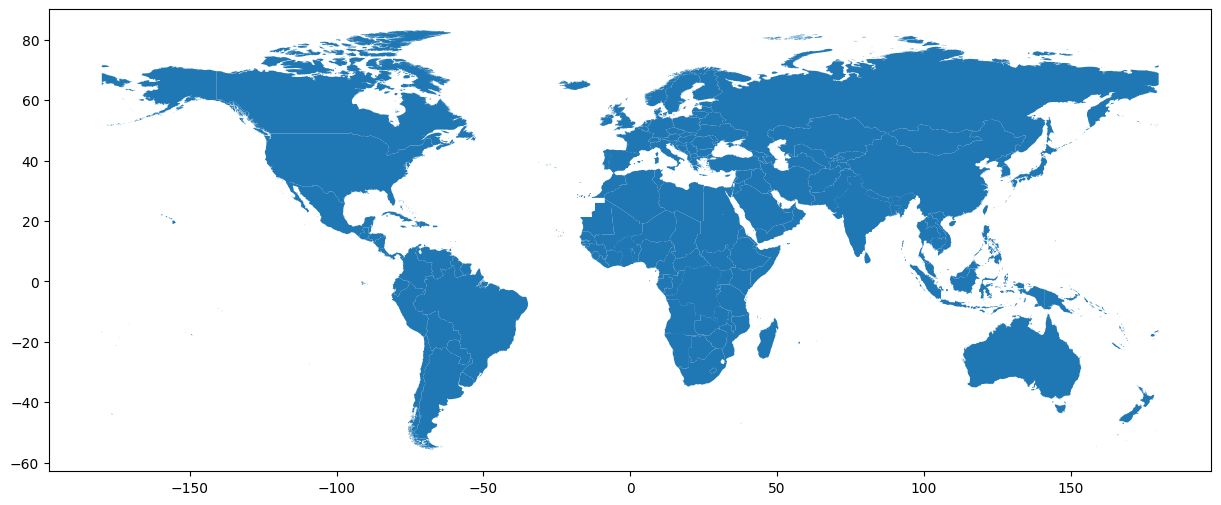

In [150]:
# then
theMapAndData.plot(figsize=(15, 10))




### Preprocessing: aggregating



In [151]:
justDots = theMapAndData.copy()
dot_value = 0.5
justDots['num_dots'] = (justDots['%'] / dot_value).astype(int)

### Preprocessing: distributing dots

In [152]:
# 2. Generate the random dot locations using .sample_points()
justDots = justDots.sample_points(size=justDots['num_dots']).explode(index_parts=True)

In [153]:
justDots

0    0     POINT (60.72381 34.20679)
     1       POINT (61.0901 34.8463)
     2     POINT (61.39041 29.71769)
     3       POINT (61.957 30.27022)
     4      POINT (62.24292 30.9625)
                     ...            
188  4    POINT (122.97653 -4.88756)
     5    POINT (140.58994 -7.12965)
189  0    POINT (126.42577 -8.66561)
     1    POINT (126.48904 -8.66323)
     2    POINT (126.97095 -8.41911)
Name: sampled_points, Length: 2628, dtype: geometry

In [154]:
# what is it?
type(justDots)

geopandas.geoseries.GeoSeries

### Preprocessing: building GDF from GS

In [155]:
justDots.reset_index(drop=True, inplace=True)
world_dots = gpd.GeoDataFrame(geometry=justDots)
world_dots

,geometry
0,POINT (60.72381 34.20679)
1,POINT (61.0901 34.8463)
2,POINT (61.39041 29.71769)
3,POINT (61.957 30.27022)
4,POINT (62.24292 30.9625)
...,...
2623,POINT (122.97653 -4.88756)
2624,POINT (140.58994 -7.12965)
2625,POINT (126.42577 -8.66561)
2626,POINT (126.48904 -8.66323)


In [156]:
world_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2628 non-null   geometry
dtypes: geometry(1)
memory usage: 20.7 KB


<Axes: >

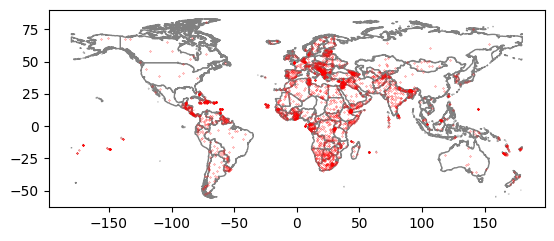

In [163]:
base = theMapAndData.plot(facecolor="white", edgecolor='grey')
justDots.sample_points(size=justDots['num_dots']) \
        .explode(index_parts=True) \
        .plot(markersize=0.05, color='red', ax=base)

<Axes: >

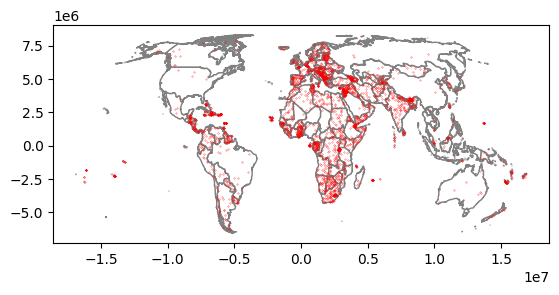

In [165]:
base = world.to_crs(8857).plot(facecolor="white", edgecolor='grey')

world_dots.to_crs(8857).plot(markersize=0.05, color='red', ax=base)

In [166]:
theMapAndData_8857 = theMapAndData.to_crs(8857)
world_dots_8857 = world_dots.to_crs(8857)

# Thematics: the PSM (Proportional Symbol Map)


### Preprocessing: GDF of centroids



In [171]:
theMapAndData_8857_centroids = theMapAndData_8857.copy()
theMapAndData_8857_centroids['geometry'] = theMapAndData_8857_centroids['geometry'].centroid

In [175]:
theMapAndData_8857_centroids['size'] = theMapAndData_8857_centroids['%'].apply(lambda x: (x**0.5) * 2)

## or
# import numpy as np
# Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: np.log10(x))

We got the basics, then:

<Axes: >

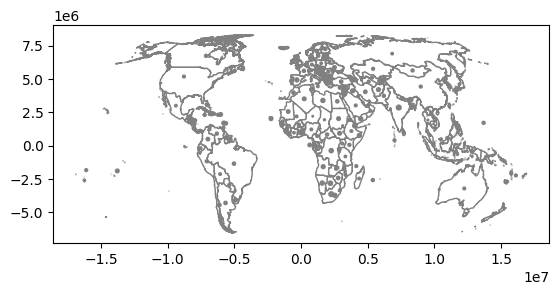

In [177]:
base = theMapAndData_8857.plot(facecolor="white", edgecolor='grey')

theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color='grey'
)

In [178]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 17.4 MB/s eta 0:00:00


Keep in mind that the standard way of computing centroids may bring some trouble. Let´s plot Seychelles:

In [180]:
# Crear el mapa base con el polígono de Seychelles filtrado en theMapAndData_8857
base = theMapAndData_8857[theMapAndData_8857['Country'] == "SEYCHELLES"].explore()

# Añadir el punto centroidal en rojo sobre ese mapa base
world_dots_8857[world_dots_8857['Country'] == "SEYCHELLES"].explore(m=base, color="red")


/tmp/ipython-input-232423838.py:2: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  base = theMapAndData_8857[theMapAndData_8857['Country'] == "SEYCHELLES"].explore()
/tmp/ipython-input-232423838.py:5: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  theMapAndData_8857_centroids[theMapAndData_8857_centroids['Country'] == "SEYCHELLES"].explore(m=base, color="red")


In [181]:
# replace the points
world_dots_8857["geometry"] = theMapAndData_8857.representative_point()

In [183]:
base = theMapAndData_8857[theMapAndData_8857['Country'] == "SEYCHELLES"].explore()
world_dots_8857[world_dots_8857['Country'] == "SEYCHELLES"].explore(m=base, color="red")

/tmp/ipython-input-3512163832.py:1: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  base = theMapAndData_8857[theMapAndData_8857['Country'] == "SEYCHELLES"].explore()
/tmp/ipython-input-3512163832.py:2: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  theMapAndData_8857_centroids[theMapAndData_8857_centroids['Country'] == "SEYCHELLES"].explore(m=base, color="red")


### Preprocessing: Computing new columns



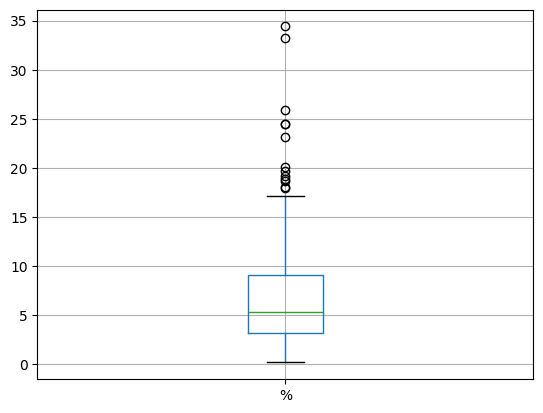

In [184]:
boxplotInfo = theMapAndData.boxplot(column='%', return_type="dict")

In [185]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([23.2, 24.5, 19.7, 25.9, 20.1, 24.5, 34.4, 18.0, 18.7, 33.2, 18.9,
       18.1, 19.2], dtype=object)

In [186]:
theMapAndData_8857_centroids[theMapAndData_8857_centroids['%'].isin(outliers)]

,Country,geometry,slug,%,date_of_information,ranking,region,size
12,BOTSWANA,POINT (2201221.267 -2809166.362),botswana,23.2,2024,185,Africa,9.633276
24,BHUTAN,POINT (8198023.349 3453721.752),west-bank,24.5,2022,186,Middle East,9.899495
34,DEMOCRATIC REPUBLIC OF THE CONGO,POINT (2261167.581 -366628.064),congo-republic-of-the,19.7,2024,183,Africa,8.876936
46,DJIBOUTI,POINT (4038310.824 1504267.133),djibouti,25.9,2024,188,Africa,10.178409
62,GABON,POINT (1130001.189 -75876.847),gabon,20.1,2024,184,Africa,8.966605
65,GHANA,POINT (-115119.235 1020017.928),gaza-strip,24.5,2022,187,Middle East,9.899495
79,INDIA,POINT (7327548.576 2867406.993),eswatini,34.4,2024,190,Africa,11.730303
88,JORDAN,POINT (3278069.42 3911673.636),jordan,18.0,2024,178,Middle East,8.485281
103,LIBYA,POINT (1639509.421 3396552.514),libya,18.7,2024,180,Africa,8.648699
146,SOUTH AFRICA,POINT (2265186.948 -3631305.245),south-africa,33.2,2024,189,Africa,11.523888


In [190]:
theMapAndData_8857_centroids['percent_outlier'] = theMapAndData_8857_centroids['%'].isin(outliers) * 1

## see
theMapAndData_8857_centroids

,Country,geometry,slug,%,date_of_information,ranking,region,size,percent_outlier
0,AFGHANISTAN,POINT (5805446.549 4209755.744),afghanistan,13.3,2024,168,South Asia,7.293833,0
1,ALGERIA,POINT (238502.141 3518510.55),algeria,11.5,2024,159,Africa,6.782330,0
2,AZERBAIJAN,POINT (4031853.414 4952418.885),azerbaijan,5.6,2024,106,Central Asia,4.732864,0
3,ALBANIA,POINT (1693159.081 5046716.937),albania,10.3,2024,150,Europe,6.418723,0
4,ARMENIA,POINT (3813099.478 4952268.37),armenia,13.4,2024,169,Central Asia,7.321202,0
...,...,...,...,...,...,...,...,...,...
185,ZAMBIA,POINT (2629786.953 -1717186.669),zambia,6.0,2024,113,Africa,4.898979,0
186,ZIMBABWE,POINT (2787117.299 -2416308.277),zimbabwe,8.6,2024,140,Africa,5.865151,0
187,SOUTH SUDAN,POINT (2891304.613 934969.388),south-sudan,12.5,2023,166,Africa,7.071068,0
188,INDONESIA,POINT (11222892.038 -285306.445),indonesia,3.3,2024,51,East and Southeast Asia,3.633180,0


<Axes: >

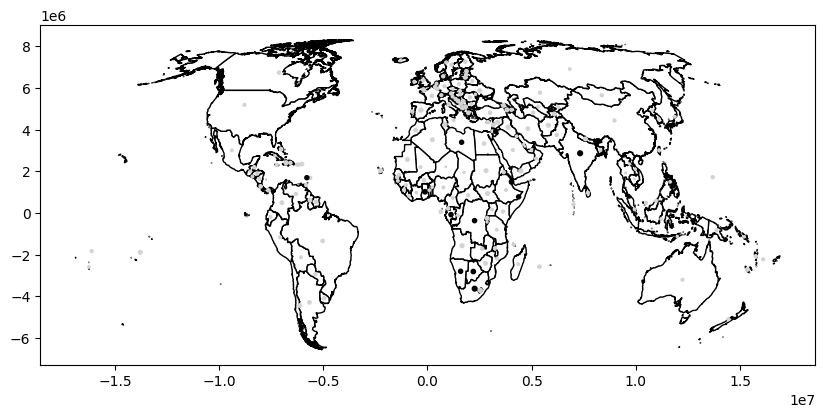

In [191]:
# Mapa base
base = theMapAndData_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Definir el mapa de colores para los outliers
mapcolor = {1: 'black', 0: 'lightgrey'}

# Graficar los centroides con color según si son outliers o no
theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color=theMapAndData_8857_centroids['percent_outlier'].map(mapcolor)
)


In [192]:
# Create explicit copies of the DataFrames
theMapAndData_8857_centroids_out = theMapAndData_8857_centroids[
    theMapAndData_8857_centroids['percent_outlier'] == 1
].copy()

theMapAndData_8857_centroids_no_out = theMapAndData_8857_centroids[
    theMapAndData_8857_centroids['percent_outlier'] == 0
].copy()


In [197]:
theMapAndData_8857_centroids_out['size'] = theMapAndData_8857_centroids_out['%'].apply(lambda x: (x**0.5) * 2)
theMapAndData_8857_centroids_no_out['size'] = theMapAndData_8857_centroids_no_out['%'].apply(lambda x: (x**0.5) * 2)

<Axes: >

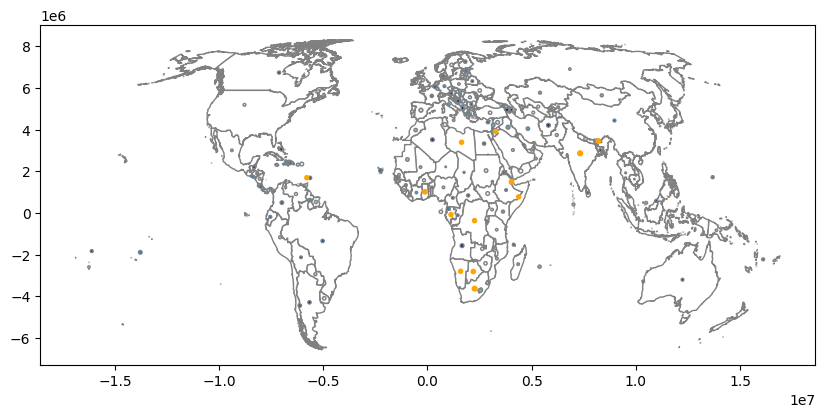

In [198]:
# Base del mapa
base = theMapAndData_8857.plot(color='white', edgecolor='grey', figsize=(10, 10))

# Puntos que NO son outliers (color gradiente)
theMapAndData_8857_centroids_no_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_no_out['size'],
    edgecolor='grey',
    c=theMapAndData_8857_centroids_no_out['size'],  # color por tamaño
    cmap='Blues_r'
)

# Puntos que SON outliers (color fijo)
theMapAndData_8857_centroids_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_out['size'],
    color='orange'
)


# Thematics: Choropleths



* * This **IS** a choropleth:

<Axes: >

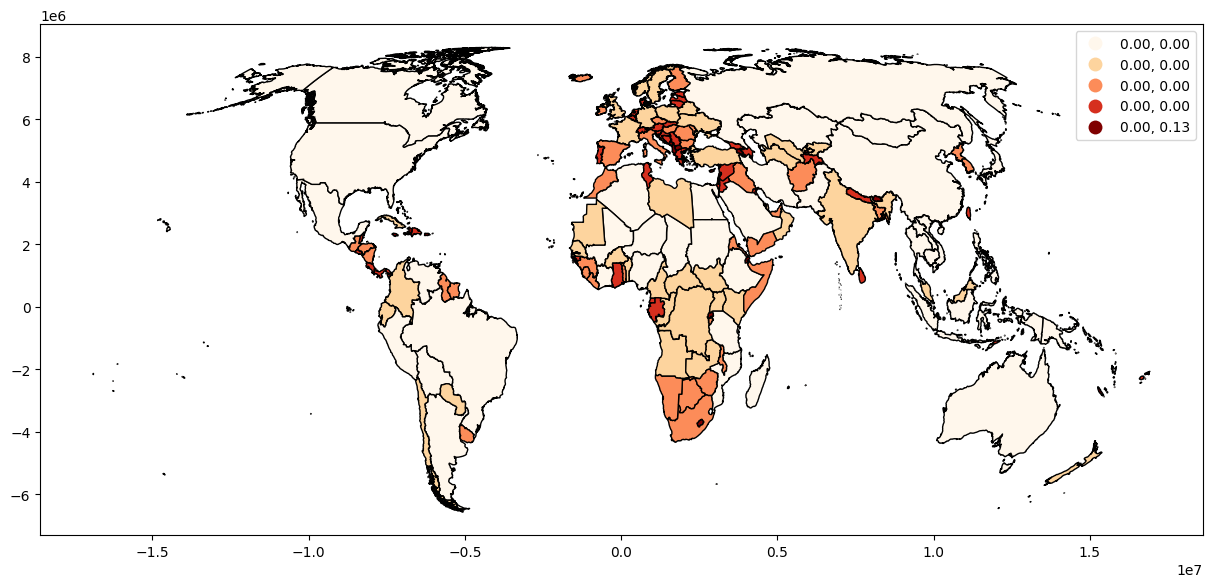

In [202]:
# Log transform para evitar que los outliers "aplanen" la escala
theMapAndData_8857['log_desempleo_km2'] = np.log1p(theMapAndData_8857['desempleo_por_km2'])

# Graficar con esquema de cuantiles
theMapAndData_8857.plot(
    column='log_desempleo_km2',
    cmap='OrRd',
    scheme='quantiles',
    k=5,
    legend=True,
    edgecolor='black',
    figsize=(15, 10)
)


### Preprocessing: Discretizing

In [204]:
## do you have these installed?
! pip show numba mapclassify numpy

Name: numba
Version: 0.60.0
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: llvmlite, numpy
Required-by: cudf-cu12, cuml-cu12, dask-cuda, distributed-ucxx-cu12, librosa, numba-cuda, pynndescent, shap, stumpy, umap-learn
---
Name: mapclassify
Version: 2.10.0
Summary: Classification Schemes for Choropleth Maps.
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: networkx, numpy, pandas, scikit-learn, scipy
Required-by: 
---
Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:


In [205]:
# Calcular la "intensidad" de porcentaje de desempleo por km²
theMapAndData_8857['desempleo_por_km2'] = theMapAndData_8857['%'] / theMapAndData_8857['sq_km']


In [206]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar = theMapAndData_8857['%']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

In [207]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

<Axes: ylabel='Classifier'>

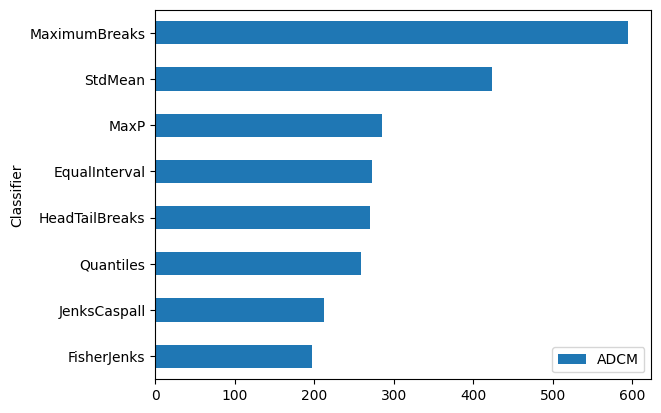

In [208]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

In [209]:
theMapAndData_8857['desempleo_densidad_FJ5'] = fj5.yb

In [210]:
# there you are
theMapAndData_8857[['%', 'desempleo_densidad_FJ5']].head(20)

,%,desempleo_densidad_FJ5
0,13.3,2
1,11.5,2
2,5.6,1
3,10.3,2
4,13.4,2
5,14.5,3
6,4.6,1
7,7.9,1
8,4.1,0
9,5.5,1


In [211]:
# Renombrar clases numéricas por etiquetas interpretables
newLabelsForLevels = {
    0: "0_VeryLow",
    1: "1_Low",
    2: "2_Middle",
    3: "3_High",
    4: "4_VeryHigh"
}

# Aplicar renombramiento sobre la columna de clasificación
theMapAndData_8857['desempleo_densidad_FJ5_cat'] = theMapAndData_8857.loc[:, 'desempleo_densidad_FJ5'].replace(newLabelsForLevels)

# Ver las primeras 20 filas
theMapAndData_8857[['%', 'desempleo_densidad_FJ5', 'desempleo_densidad_FJ5_cat']].head(20)


,%,desempleo_densidad_FJ5,desempleo_densidad_FJ5_cat
0,13.3,2,2_Middle
1,11.5,2,2_Middle
2,5.6,1,1_Low
3,10.3,2,2_Middle
4,13.4,2,2_Middle
5,14.5,3,3_High
6,4.6,1,1_Low
7,7.9,1,1_Low
8,4.1,0,0_VeryLow
9,5.5,1,1_Low


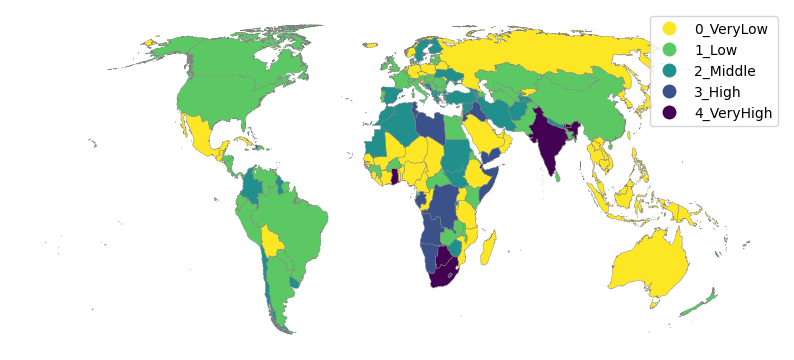

In [213]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

theMapAndData.plot(
    column='desempleo_densidad_FJ5_cat',  # variable categórica para colorear
    cmap='viridis_r',                     # conjunto de colores (puedes cambiar)
    categorical=True,                     # interpretar como categorías
    edgecolor='grey',                     # color del borde de los países
    linewidth=0.3,                       # grosor del borde
    legend=True,                         # mostrar leyenda
    ax=ax
)

ax.set_axis_off()  # quitar ejes

plt.show()


# Saving



In [214]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_3
_24
_31
_53
_80
theMapAndData
Africa
region
Africa_dots
_118
world_dots
_119
_124
_155
justDots_gdf
theMapAndData_8857
world_dots_8857
theMapAndData_8857_centroids
_186
_188
_190
theMapAndData_8857_centroids_out
theMapAndData_8857_centroids_no_out


These are the ones needed in R:

In [215]:
# for choropleth and base map
theMapAndData_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Country                     190 non-null    object  
 1   geometry                    190 non-null    geometry
 2   slug                        190 non-null    object  
 3   %                           190 non-null    float64 
 4   date_of_information         190 non-null    int64   
 5   ranking                     190 non-null    int64   
 6   region                      190 non-null    object  
 7   sq_km                       190 non-null    float64 
 8   desempleo_por_km2           190 non-null    float64 
 9   log_desempleo_km2           190 non-null    float64 
 10  desempleo_densidad_FJ5      190 non-null    int64   
 11  desempleo_densidad_FJ5_cat  190 non-null    object  
dtypes: float64(4), geometry(1), int64(3), object(4)
memory usage: 17.9+ KB

In [217]:
# for DDMs
theMapAndData_dots_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  190 non-null    geometry
dtypes: geometry(1)
memory usage: 20.7 KB


In [218]:
# for PSMs
theMapAndData_8857_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              190 non-null    object  
 1   geometry             190 non-null    geometry
 2   slug                 190 non-null    object  
 3   %                    190 non-null    float64 
 4   date_of_information  190 non-null    int64   
 5   ranking              190 non-null    int64   
 6   region               190 non-null    object  
 7   size                 190 non-null    float64 
 8   percent_outlier      190 non-null    int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 13.5+ KB


In [219]:
# for PSMs
theMapAndData_8857_centroids_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13 entries, 12 to 183
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              13 non-null     object  
 1   geometry             13 non-null     geometry
 2   slug                 13 non-null     object  
 3   %                    13 non-null     float64 
 4   date_of_information  13 non-null     int64   
 5   ranking              13 non-null     int64   
 6   region               13 non-null     object  
 7   size                 13 non-null     float64 
 8   percent_outlier      13 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 1.0+ KB


In [220]:
# for PSMs
theMapAndData_8857_centroids_no_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 177 entries, 0 to 189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              177 non-null    object  
 1   geometry             177 non-null    geometry
 2   slug                 177 non-null    object  
 3   %                    177 non-null    float64 
 4   date_of_information  177 non-null    int64   
 5   ranking              177 non-null    int64   
 6   region               177 non-null    object  
 7   size                 177 non-null    float64 
 8   percent_outlier      177 non-null    int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 13.8+ KB


In [224]:
theMapAndData_8857.to_file("world_8857.gpkg",driver='GPKG',layer='continent')
world_dots_8857.to_file("world_8857.gpkg",driver='GPKG',layer='population_ddm')
theMapAndData_8857_centroids.to_file("world_8857.gpkg",driver='GPKG',layer='population_psm')
theMapAndData_8857_centroids_out.to_file("world_8857.gpkg",driver='GPKG',layer='outlier_population_psm')
theMapAndData_8857_centroids_no_out.to_file("world_8857.gpkg",driver='GPKG',layer='no_outlier_population_psm')